In [1]:
import cv2
import torch
# import visdom
import agent
import numpy as np
# from data_loader import Generator
from lib.dataset import BuildDataLoader, LaneDataset
from lib.utils import setup_exp_dir, set_config
from parameters import Parameters
import test
import evaluation
import argparse
import os
import logging
import matplotlib.pyplot as plt


In [2]:
cfg = set_config('cfgs/debug.yaml')

In [3]:
val_dataset = LaneDataset(cfg, 'val')

In [ ]:
train_dataset = LaneDataset(cfg, 'train')

In [4]:
loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=2,
        shuffle=False,
        )
len(loader)

50000

In [5]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

loader_iter = iter(loader)

In [6]:
import agent
lane_agent = agent.Agent(cfg, None, False)

In [24]:
imgs, labels, lanes, idxs = next(loader_iter)

torch.Size([10, 62]) torch.Size([10, 62])
(3, 32, 64) (1, 32, 64)


<function matplotlib.pyplot.show(*args, **kw)>

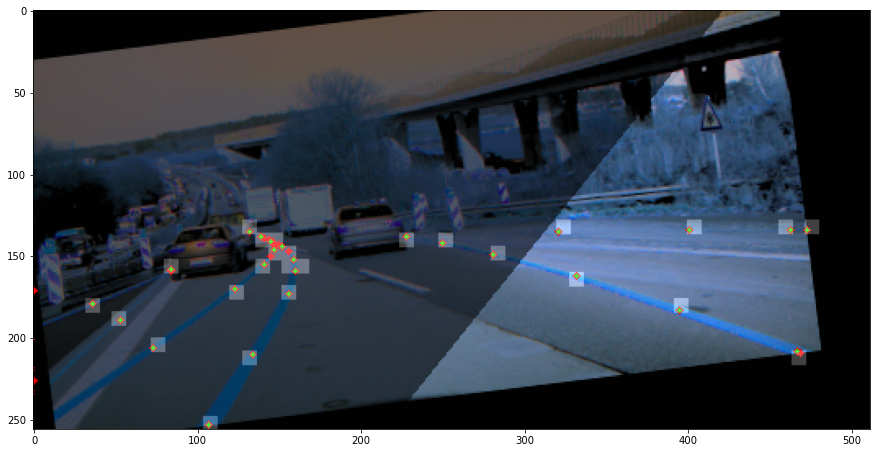

In [27]:
#imgs, labels, lanes, idxs = next(loader_iter)

im = imgs[0].permute(1, 2, 0).contiguous()
im = im.numpy()
im = im * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
im = (im * 255).astype(np.uint8)

lns_x, lns_y = lanes
ln_x = lns_x[0]
ln_y = lns_y[0]
print(ln_x.shape, ln_y.shape)

for xs, ys in zip(ln_x, ln_y):
    for x, y in zip(xs, ys):
        cv2.circle(im, (x, y), 2, (255, 0, 0), -1)

# gts, gtns, gtis = labels
gts, gtns = lane_agent.make_ground_truth_point(0, lns_x, lns_y)
gt, gtn = gts[0], gtns[0]
print(gt.shape, gtn.shape)

blk = np.zeros(im.shape, np.uint8)

gsize = 8 # cfg['dataset']['resize_ratio']
_, ngy, ngx = gt.shape
for gy in range(ngy):
    for gx in range(ngx):
        cls = gt[0, gy, gx]
        if cls > 0:
            offset_x = gt[1, gy, gx]
            offset_y = gt[2, gy, gx]
            pt1 = (gx*gsize, gy*gsize)
            pt2 = (gx*gsize+gsize, gy*gsize+gsize)
            cv2.rectangle(blk, pt1, pt2, (255, 255, 255), cv2.FILLED)
            cv2.circle(im, ( int((gx+offset_x)*gsize), int((gy+offset_y)*gsize) ), 1, (0, 255, 0), -1)

out = cv2.addWeighted(im, 1.0, blk, 0.25, 1)

plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.imshow(blk)
plt.imshow(out)
plt.show

numpy.ndarray

19882
(9, 87) (9, 87)
(256, 512, 3) torch.Size([3, 64, 128]) torch.Size([1, 64, 128]) torch.Size([1, 8192, 8192])


<function matplotlib.pyplot.show(*args, **kw)>

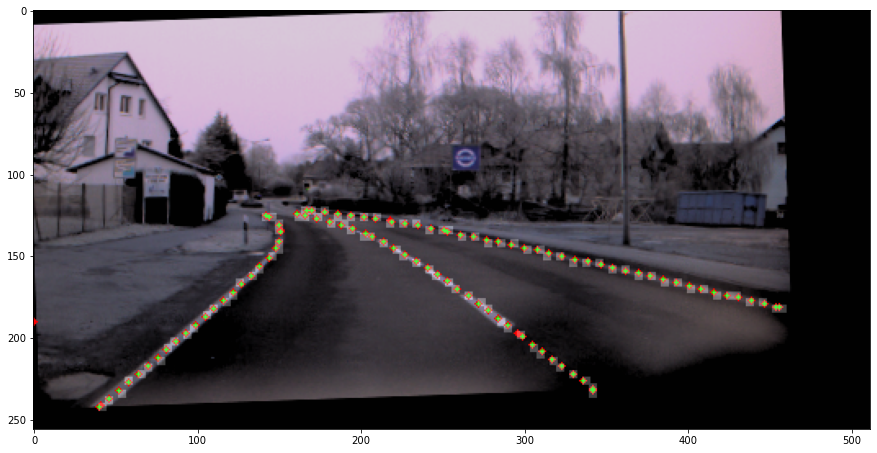

In [10]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

# curve: 19882 19884 19876 19879
# too many lines: 19885
img, label, lanes, idx = val_dataset.__getitem__(19882)
xss, yss = lanes

print(idx)

im = img.permute(1, 2, 0).contiguous()
im = im.numpy()
im = im * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
im = (im * 255).astype(np.uint8)

print(xss.shape, yss.shape)
for xs, ys in zip(xss, yss):
    for x, y in zip(xs, ys):
        # print(x, y)
        cv2.circle(im, (x, y), 2, (255, 0, 0), -1)

gt, gtn, gti = label
print(im.shape, gt.size(), gtn.size(), gti.size())

blk = np.zeros(im.shape, np.uint8)
gsize = cfg['dataset']['resize_ratio']
for gy in range(gt.size(1)):
    for gx in range(gt.size(2)):
        cls = gt[0, gy, gx]
        if cls > 0:
            offset_x = gt[1, gy, gx]
            offset_y = gt[2, gy, gx]
            # print(offset_x, offset_y)
            # print(gx*8, gy*8) (?+gx)*8
            # cv2.rectangle(im, (gx*8, gy*8), (gx*8+8, gy*8+8), (128, 128, 0), -1)
            
            
            pt1 = (gx*gsize, gy*gsize)
            pt2 = (gx*gsize+gsize, gy*gsize+gsize)
            cv2.rectangle(blk, pt1, pt2, (255, 255, 255), cv2.FILLED)
            
            
            cv2.circle(im, ( (gx+offset_x)*gsize, (gy+offset_y)*gsize ), 1, (0, 255, 0), -1)

out = cv2.addWeighted(im, 1.0, blk, 0.25, 1)

plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.imshow(blk)
plt.imshow(out)
plt.show

In [7]:
import os, glob, cv2

In [4]:
pattern = os.path.join('dataset/lane_detection/test/images', '*.bmp')
imgs = glob.glob(pattern)

In [5]:
len(imgs)

54223

In [8]:
img = cv2.imread(imgs[12])

In [9]:
54223 / 16

3388.9375

In [1]:
import torch
from lib.backbone import resnet

In [2]:
bb = resnet.__dict__['resnet50'](pretrained=True)

In [3]:
img = torch.rand(2,3,256,512)
out = bb(img)

In [4]:
for k, v in out.items():
    print(k, v.size())

stem torch.Size([2, 64, 64, 128])
res1 torch.Size([2, 256, 64, 128])
res2 torch.Size([2, 512, 32, 64])
res3 torch.Size([2, 1024, 16, 32])
res4 torch.Size([2, 2048, 8, 16])


In [1]:
import torch
from hourglass_network import curve_lane_net 


In [2]:
model = curve_lane_net()

In [3]:
img = torch.rand(2,3,256,512)
outs = model(img)

In [11]:
for out in outs:
    conf, offset, ins = out
    print(conf.size(), offset.size(), ins.size())

torch.Size([2, 1, 64, 128]) torch.Size([2, 2, 64, 128]) torch.Size([2, 4, 64, 128])
torch.Size([2, 1, 64, 128]) torch.Size([2, 2, 64, 128]) torch.Size([2, 4, 64, 128])
torch.Size([2, 1, 32, 64]) torch.Size([2, 2, 32, 64]) torch.Size([2, 4, 32, 64])
torch.Size([2, 1, 32, 64]) torch.Size([2, 2, 32, 64]) torch.Size([2, 4, 32, 64])


In [17]:
lanes = torch.rand(3,10,1)
for i, it in enumerate(lanes):
    print(i, type(it), it.size())
    for pt in it:
        print(pt/1.0)

0 <class 'torch.Tensor'> torch.Size([10, 1])
tensor([0.8786])
tensor([0.3386])
tensor([0.3296])
tensor([0.2205])
tensor([0.6922])
tensor([0.7475])
tensor([0.4546])
tensor([0.4063])
tensor([0.4144])
tensor([0.8504])
1 <class 'torch.Tensor'> torch.Size([10, 1])
tensor([0.9737])
tensor([0.4124])
tensor([0.2342])
tensor([0.2288])
tensor([0.2822])
tensor([0.3158])
tensor([0.8127])
tensor([0.8652])
tensor([0.8344])
tensor([0.2645])
2 <class 'torch.Tensor'> torch.Size([10, 1])
tensor([0.7481])
tensor([0.2429])
tensor([0.9604])
tensor([0.0175])
tensor([0.9452])
tensor([0.7430])
tensor([0.9567])
tensor([0.6080])
tensor([0.7360])
tensor([0.6095])
